In [1]:
#cd("~/Projects/ASTRAL/soundings/src/")

# activate the environment
# an environment is just a path with Manifest.toml and Project.toml
using Pkg; Pkg.activate("..")

using Revise
#using Regex
using CSV, DataFrames
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings`


In [2]:
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
hdr = [4,4,4,4,4,4,7] # 7 header lines for Vsk, 4 for others

# dates are formatted a variety of different ways

#datematcher = ["yyyymmdd-HH", "ddUyyyy", "dduuuyy"]
#ldm = length.(datematcher)
#datefm = Dates.DateFormat.(datematcher)
# doesn't handle undelimited month names

"Parse the various date formats in the file names. Only works for 3-letter month (or May)."
function imd_file_date(fn)
    if fn[1:6]=="43150-" && all(isnumeric, fn[[7:14; 16:17]]) # 43150 Visakhap. WMO station ID
        dt = Dates.DateTime(fn[7:17], "yyyymmdd-HH")
    elseif fn[10:12]=="VSK" && all(isnumeric, fn[[1:2; 6:9]])  # Visakhap.
        dt = Dates.DateTime(fn[1:9], "ddUUUyyyy")
    elseif all(isnumeric, fn[[1:8; 10:11]])
        dt = Dates.DateTime(fn[1:11], "yyyymmdd-HH")
    else
        # expect undelimited 3-letter month
        if all(isnumeric, fn[[1:2; 6:7]])
            if isletter(fn[8])
                dt = DateTime( 2000+year(DateTime(fn[6:7], "yy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            elseif all(isnumeric, fn[8:9])
                dt = DateTime( year(DateTime(fn[6:9], "yyyy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            end
        end
    end
    return dt
end


imd_file_date

In [3]:
stationdir = lowercase(CamelStations[1]) # e.g., lowercase("Visakhapatnam")

# read standard named files in the station's directory
soundingfiles(stationdir; reldatapath=reldatapath) = filter(x -> occursin(r"(?i)(May|Standard_Summary|Standard-Summary|Standard Summary).*(\.txt)$(?-i)",x),
               readdir(joinpath(reldatapath, stationdir)) ) 
files = soundingfiles( stationdir ) 

# remove duplicate times uniqueidx(v) = unique(i -> v[i], eachindex(v))
uniqueidx(v) = unique(i -> v[i], eachindex(v))

fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order
collect(zip(fdt[ui[ord]], files[ui[ord]]))

37-element Vector{Tuple{DateTime, String}}:
 (DateTime("2023-04-30T23:00:00"), "20230430-23-Standard Summary.txt")
 (DateTime("2023-05-01T23:00:00"), "20230501-23-Standard Summary.txt")
 (DateTime("2023-05-02T23:00:00"), "20230502-23-Standard Summary.txt")
 (DateTime("2023-05-03T23:00:00"), "20230503-23-Standard Summary.txt")
 (DateTime("2023-05-04T23:00:00"), "20230504-23-Standard Summary.txt")
 (DateTime("2023-05-05T23:00:00"), "20230505-23-Standard Summary.txt")
 (DateTime("2023-05-06T23:00:00"), "20230506-23-Standard Summary.txt")
 (DateTime("2023-05-07T23:00:00"), "20230507-23-Standard Summary.txt")
 (DateTime("2023-05-08T23:00:00"), "20230508-23-Standard Summary.txt")
 (DateTime("2023-05-09T23:00:00"), "20230509-23-Standard Summary.txt")
 (DateTime("2023-05-11T00:00:00"), "20230511-00-Standard Summary.txt")
 (DateTime("2023-05-11T23:00:00"), "20230511-23-Standard Summary.txt")
 (DateTime("2023-05-12T23:00:00"), "20230512-23-Standard Summary.txt")
 ⋮
 (DateTime("2023-05-25T23:00:0

In [4]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind]) # .& .!ismissing.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-5.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        s1[j] += isfinite(x[i]) ? x[i] : 0
        # s2[j] += x[i]^2
        ns[j] += 1.0*isfinite(x[i])
    end
    
    s1 ./ ns # mean
end

pavg

In [50]:
# 1 file example

station = lowercase("Ahmedabad")
files = soundingfiles(station)
#filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x), readdir(joinpath(reldatapath, station) ))

# dt = imd_file_date(files[ui[ord[8]]])

# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order

# reader functions
# single-character replacer
# handles tabs and \u00b0 degree character °
stripjunk(f) = IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )
function read_sonde(file; header=( station=="visakhapatnam" ? 7 : 3 ) )
    CSV.read( stripjunk(file),
        DataFrame, header=header, delim=",", stripwhitespace=true, ignorerepeated=true )
end

# test read
df = read_sonde( joinpath(reldatapath, station, files[ui[ord[2]]]),
                 header=( station=="visakhapatnam" ? 7 : 3 )      )
isempty(df)

true

# Column headers 

Chennai, Karaikal, Kochi, Kolkata, Ahmedabad, Pune
```
Time,     p(hPa),    T(?C),    U(%),      Dew(?C),     Geo(gpm),   Geo(gpft),    Wdir(?),    Wspd(m/s),    Asc(m/m),    Avg Asc(m/m),    Azimuth(?),   Range(m),    Elevation(?),
```
Mangalore, PortBlair
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
Visakhapatnam
43150-20230512-00-Standard-Summary.txt, 43150-20230520-00-Standard-Summary.txt: 3 headerlines
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
all other Visakhapatnam: 7 headerlines

Simon edited the 2 Vsk files to make them have 7

In [51]:
NamePatterns = [ 
    ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"], #Visakhapatnam style 1
    ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"] # Mangalore, Visakhapatnam
    ]

2-element Vector{Vector{String}}:
 ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"]
 ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"]

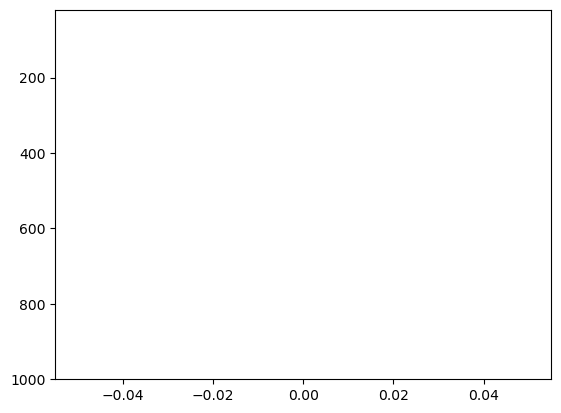

"ahmedabad"

In [52]:
"extract column data by name"
function get_sounding_cols(df, station)
    if isempty(df)
        # p = [missing]
        # T = [missing]
        # Td = [missing]
        # rh= [missing]
        # z = [missing]
        # wspd = [missing]
        # wdir = [missing]
        p = []
        T = []
        Td = []
        rh= []
        z = []
        wspd = []
        wdir = []
    else
        if in(station, ["mangalore", "visakhapatnam", "portblair"])
            p = df[!,"P(hPa)"][:]
            T = df[!,"T(C)"][:]
            Td = df[!,"Dew(C)"][:]
            rh = df[!,"U(%)"][:]
            z = df[!,"Geo(gpm)"][:]
            wspd = df[!,"Wspd(m/s)"][:]
            wdir = df[!,"Wdir(d)"][:]
        else # slightly different keys
            p = df[!,"p(hPa)"][:]
            rh = df[!,"U(%)"][:]
            z = df[!,"Geo(gpm)"][:]
            wspd = df[!,"Wspd(m/s)"][:]
            if "T(dC)" in names(df)
                T = df[!,"T(dC)"][:]
                Td = df[!,"Dew(dC)"][:]
                wdir = df[!,"Wdir(d)"][:]
            elseif "T(Deg.C)" in names(df) # another variation
                T = df[!,"T(Deg.C)"][:]
                Td = df[!,"Dew(Deg.C)"][:]
                wdir = df[!,"Wdir(Deg)"][:]
            end

        end
    end
    u = -wspd .* sin.(pi/180.0*wdir)
    v = -wspd .* cos.(pi/180.0*wdir)
    
    return p, T,Td, rh,z, wspd,wdir, u,v
end

p, T,Td, rh,z, wspd,wdir, u,v = get_sounding_cols(df, station)

m2n(x) = ismissing(x) ? NaN : x

# test plot
clf()
plot( m2n.(T), m2n.(p), label="Temperature (C)")
ylim(1000, 20)
station

In [53]:
# sounding variable functions

meanfinite(x, dims) = sum(x, dims=dims)./sum(isfinite, x, dims=dims)
anom(x; dims=ndims(x)) = x .- meanfinite(x, dims)

"Exner function T/θ = (p/p_0)^Rd/cp"
Exner(p) = (p/1000.0)^0.287 # = T/theta
th(T,p) = T/Exner(p)

th (generic function with 1 method)

In [54]:
# pressure levels to interploate to
dp = 5.0
plevs = 1020.0:-dp:0.0

# test interpolation
if !isempty(df)
    upi = uniqueidx(p)
    plot(plevs, m2n.(itp(u[upi], p[upi])[plevs]))
    # test averaging
    # plot(plevs, pavg(u, p plevs=plevs))
    
    plot(m2n.(p), m2n.(wspd))
    u_pl = pavg(u, p, plevs=plevs)
    # plev is the level geometrically above and dynamically (pressure) below the binned observations
    # probably suitable for pcolormesh
    plot(plevs.+dp/2, u_pl)
end

In [57]:
# inventory files, times
station="visakhapatnam" # "visakhapatnam"
    # read standard named files in the station's directory
    files = soundingfiles(station)
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    cat(files[ui[ord]], fdt[ui[ord]], dims=2)

37×2 Matrix{Any}:
 "01MAY2023VSK.txt"                        2023-05-01T00:00:00
 "02MAY2023VSK.txt"                        2023-05-02T00:00:00
 "03MAY2023VSK.txt"                        2023-05-03T00:00:00
 "04MAY2023VSK.txt"                        2023-05-04T00:00:00
 "05MAY2023VSK.txt"                        2023-05-05T00:00:00
 "06MAY2023VSK.txt"                        2023-05-06T00:00:00
 "07MAY2023VSK.txt"                        2023-05-07T00:00:00
 "08MAY2023VSK.txt"                        2023-05-08T00:00:00
 "09MAY2023VSK.txt"                        2023-05-09T00:00:00
 "10MAY2023VSK.txt"                        2023-05-10T00:00:00
 "43150-20230511-00-Standard-Summary.txt"  2023-05-11T00:00:00
 "43150-20230512-00-Standard-Summary.txt"  2023-05-12T00:00:00
 "43150-20230513-00-Standard-Summary.txt"  2023-05-13T00:00:00
 ⋮                                         
 "43150-20230526-00-Standard-Summary.txt"  2023-05-26T00:00:00
 "43150-20230527-00-Standard-Summary.txt"  2023-05-27T00

In [69]:
# test read visakhapatanm
"number of headerlines"
function hdrs( station, file )
    # these visakhapatnam files have fewer headerlines
    bollox = ["43150-20230527-00-Standard-Summary.txt",
              "43150-20230605-00-Standard-Summary.txt",
              "43150-20230606-00-Standard-Summary.txt" ]
    (station=="visakhapatnam" && !(file in bollox)) ? 7 : 3
end

for ti in ui[ord]
    fn = joinpath(reldatapath, station, files[ti])
    hdr = (station=="visakhapatnam" && !(files[ti] in bollox)) ? 7 : 3
    df = read_sonde( joinpath(reldatapath, station, files[ti]), header=hdrs( station, files[ti] ) )
    @show files[ti]
    if !isempty(df)
        # extract ungridded hi-res data
        p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
    end
end

files[ti] = "01MAY2023VSK.txt"
files[ti] = "02MAY2023VSK.txt"
files[ti] = "03MAY2023VSK.txt"
files[ti] = "04MAY2023VSK.txt"
files[ti] = "05MAY2023VSK.txt"
files[ti] = "06MAY2023VSK.txt"
files[ti] = "07MAY2023VSK.txt"
files[ti] = "08MAY2023VSK.txt"
files[ti] = "09MAY2023VSK.txt"
files[ti] = "10MAY2023VSK.txt"
files[ti] = "43150-20230511-00-Standard-Summary.txt"
files[ti] = "43150-20230512-00-Standard-Summary.txt"
files[ti] = "43150-20230513-00-Standard-Summary.txt"
files[ti] = "43150-20230514-00-Standard-Summary.txt"
files[ti] = "43150-20230515-00-Standard-Summary.txt"
files[ti] = "43150-20230516-00-Standard-Summary.txt"
files[ti] = "43150-20230517-00-Standard-Summary.txt"
files[ti] = "43150-20230518-00-Standard-Summary.txt"
files[ti] = "43150-20230519-00-Standard-Summary.txt"
files[ti] = "43150-20230520-00-Standard-Summary.txt"
files[ti] = "43150-20230521-00-Standard-Summary.txt"
files[ti] = "43150-20230522-00-Standard-Summary.txt"
files[ti] = "43150-20230523-00-Standard-Summary.txt"
f

In [70]:
"count unique soundings from each station, return maximum"
function count_max_unique_soundings(stationnames)
    nts = zeros(Int32, length(stationnames))
    
    for (sj, station) in enumerate(stationnames)
        # read standard named files in the station's directory
        files = soundingfiles(station)
        # deduplicate sounding times
        fdt = imd_file_date.(files)
        fdt12 = round.(fdt, Dates.Hour(12))
        ui = uniqueidx(fdt12)
        fdt[ui] # exact datetimes with duplicates removed
        ord = sortperm(fdt[ui]) # guarantees ascending order
        nts[sj] = length(ui)
        # @show station, nts[sj]
    end
    
    nt = maximum(nts)
end

count_max_unique_soundings

In [72]:
# start over and do a big loop to load and interpolate data to consistent levels

reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0

CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

# allocate gridded data arrays (pressure, location, launch time)
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
time = zeros(DateTime, length(stationnames), nt)

sj = 0
for station in stationnames
    @show station
    # read standard named files in the station's directory
    files = soundingfiles(station)
    sj += 1 # gridded station index
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    #collect(zip( files[ui[ord]]], fdt[ui[ord]] ))
    
    tj = 0
    for ti in ui[ord]
        fn = joinpath(reldatapath, station, files[ti])
        df = read_sonde( joinpath(reldatapath, station, files[ti]),
                 header=hdrs( station, files[ti]  ) )
        if !isempty(df)
            # extract ungridded hi-res data
            p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
            # avg variables at the next time level
            tj += 1
            time[sj,tj] = fdt[ti]
            T[  :, sj, tj] .= pavg(T_ , p_, plevs=plevs)
            Td[ :, sj, tj] .= pavg(Td_, p_, plevs=plevs)
            rh[ :, sj, tj] .= pavg(rh_, p_, plevs=plevs)
            z[  :, sj, tj] .= pavg(z_ , p_, plevs=plevs)
            u[  :, sj, tj] .= pavg(u_ , p_, plevs=plevs)
            v[  :, sj, tj] .= pavg(v_ , p_, plevs=plevs)
        else
            tj += 1
            time[sj,tj] =fdt[ti]
            # leave an empty sounding when missing
        end
    end
end

station = "ahmedabad"
station = "chennai"
station = "karaikal"
station = "kochi"
station = "kolkata"
station = "mangalore"
station = "portblair"
station = "pune"
station = "visakhapatnam"


In [73]:
# count times at each station
nt = sum(time.>DateTime(1000), dims=2)
collect(zip(CamelStations, nt))

9-element Vector{Tuple{String, Int64}}:
 ("Ahmedabad", 37)
 ("Chennai", 41)
 ("Karaikal", 35)
 ("Kochi", 35)
 ("Kolkata", 37)
 ("Mangalore", 37)
 ("PortBlair", 39)
 ("Pune", 37)
 ("Visakhapatnam", 37)

size(u[:, sj, 1:nt[sj]]) = (205, 37)


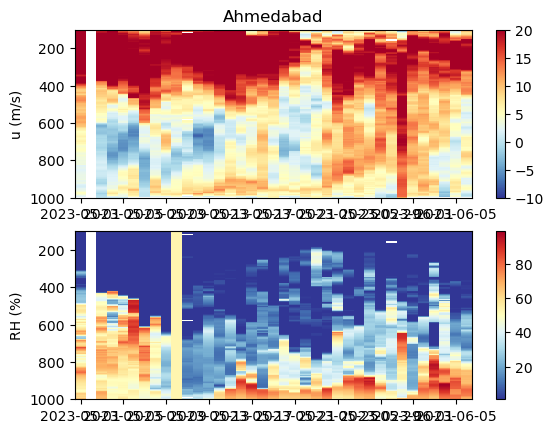

PyObject <matplotlib.colorbar.Colorbar object at 0x11efdf940>

In [76]:
# test time-pressure plot
sj = 1
@show size(u[:,sj,1:nt[sj]])

clf()
subplot(2,1,1)
# pcolormesh( time[sj,:], plevs, anom(T[:,sj,:],dims=2) )
# pcolormesh( time[sj,:], plevs, anom(th.(T[:,sj,:],plevs),dims=2), vmin=-7, vmax=7, cmap=ColorMap("RdYlBu_r") )
pcolormesh( time[sj,1:nt[sj]], plevs, u[:,sj,1:nt[sj]], vmin=-10, vmax=20, cmap=ColorMap("RdYlBu_r") )
ylim(1000, 100)
colorbar()
ylabel("u (m/s)")
title(CamelStations[sj])

subplot(2,1,2)
pcolormesh( time[sj,1:nt[sj]], plevs, rh[:,sj,1:nt[sj]], cmap=ColorMap("RdYlBu_r"))
ylim(1000, 100)
ylabel("RH (%)")
colorbar()

In [131]:
time[1,2] = DateTime(2023,5,1,23,0,0)

2023-05-01T23:00:00

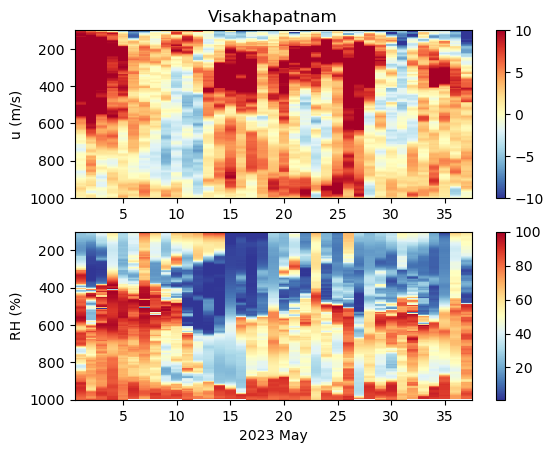

In [77]:
# make time-height plot for each station

mpldate(timestamp, offset=DateTime(2023,4,30,0,0,0)) = Dates.value(timestamp-offset)/1000/60/60/24

for sj in 1:9
    clf()
    subplot(2,1,1)
    pcolormesh( mpldate.(time[sj,1:nt[sj]]), plevs, u[:,sj,1:nt[sj]], vmin=-10, vmax=10, cmap=ColorMap("RdYlBu_r") )
    ylim(1000, 100)
    ylabel("u (m/s)")
    colorbar()
    title(CamelStations[sj])

    subplot(2,1,2)
    pcolormesh( mpldate.(time[sj,1:nt[sj]]), plevs, rh[:,sj,1:nt[sj]], cmap=ColorMap("RdYlBu_r"))
    ylim(1000, 100)
    ylabel("RH (%)")
    xlabel(Dates.format(time[sj,1], "yyyy U"))
    colorbar()
    
    savefig("../plot/$(CamelStations[sj])_u_rh.svg")
end

In [78]:
# station locations
# station, lat, lon
Loc = [
  [ "Ahmedabad", 23.03, 72.58],
  [ "Chennai", 13+(4+57/60)/60, 80+(16+30/60)/60 ],
  [ "Karaikal", 10.93, 79.83 ],
  [ "Kochi", 9.97, 76.28 ],
  [ "Kolkata", 22+(34+3/60)/60, 88+(22+12/60)/60 ], 
  [ "Mangalore", 12+(52+5/60)/60, 74+(50+33/60)/60 ],
  [ "Port Blair", 11+(40+6/60)/60, 92+(44+16/60)/60 ],
  [ "Pune", 18+(31+13/60)/60, 73+(51+24/60)/60 ],
  [ "Visakhapatnam", 17+(42+15/60)/60, 83+(17+52/60)/60 ]
      ]

9-element Vector{Vector{Any}}:
 ["Ahmedabad", 23.03, 72.58]
 ["Chennai", 13.0825, 80.275]
 ["Karaikal", 10.93, 79.83]
 ["Kochi", 9.97, 76.28]
 ["Kolkata", 22.5675, 88.37]
 ["Mangalore", 12.868055555555555, 74.8425]
 ["Port Blair", 11.668333333333333, 92.73777777777778]
 ["Pune", 18.52027777777778, 73.85666666666667]
 ["Visakhapatnam", 17.704166666666666, 83.29777777777778]

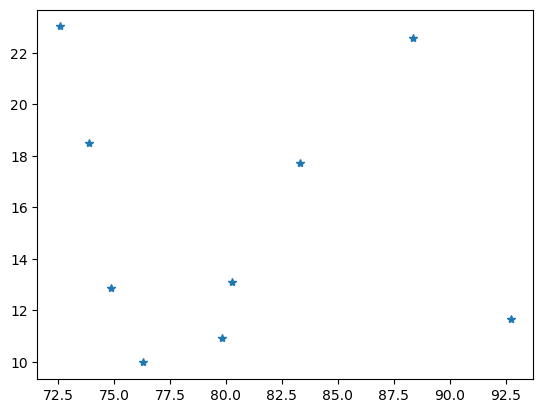

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x11f7a1f30>

In [79]:
plot( map(l -> l[3], Loc), map(l -> l[2], Loc), linestyle="", marker="*")